In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import shutil

In [2]:
# Remove old plots and create directory for new ones
dir_path = "/Users/giorgioclauser/Documents/covid_plts/italia"
shutil.rmtree(dir_path)
os.mkdir(dir_path)

In [3]:
# Set working directory to home
os.chdir("/Users/giorgioclauser/Projects/covid_ita/")

In [4]:
# Import national data
df_ita = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")

In [5]:
# Feature engineering
df_ita["prcn_tamponi_positivi_overall"] = df_ita["totale_casi"]/df_ita["tamponi"]
df_ita["prcn_tamponi_positivi_daily"] = df_ita["variazione_totale_positivi"]/(df_ita["tamponi"] - df_ita["tamponi"].shift(1))
df_ita['reference_day'] = df_ita.data.apply(lambda x: x[5:10])
df_ita['nuovi_positivi'] = df_ita['totale_positivi'] - df_ita["totale_positivi"].shift(1)
df_ita["growth_rate"] = df_ita["totale_positivi"]/df_ita["totale_positivi"].shift(1)

In [6]:
df_ita.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note,prcn_tamponi_positivi_overall,prcn_tamponi_positivi_daily,reference_day,growth_rate
153,2020-07-26T17:00:00,ITA,735,44,779,11786,12565,123,123.0,198446,...,222382.0,23736.0,246118,6560572,3922995.0,NaN,0.037515,0.003035,07-26,1.009886
154,2020-07-27T17:00:00,ITA,740,45,785,11796,12581,16,16.0,198593,...,222442.0,23844.0,246286,6586123,3942369.0,NaN,0.037395,0.000626,07-27,1.001273
155,2020-07-28T17:00:00,ITA,749,40,789,11820,12609,28,28.0,198756,...,222473.0,24015.0,246488,6634293,3967710.0,NaN,0.037154,0.000581,07-28,1.002226
156,2020-07-29T17:00:00,ITA,731,38,769,11847,12616,7,7.0,199031,...,222569.0,24207.0,246776,6690311,3998585.0,NaN,0.036886,0.000125,07-29,1.000555
157,2020-07-30T17:00:00,ITA,748,47,795,11435,12230,-386,-386.0,199796,...,222720.0,24438.0,247158,6752169,4031981.0,NaN,0.036604,-0.006240,07-30,0.969404


In [7]:
# Giorni con decreti:
day_decreti = ['03-04', '03-08', '03-09', '03-11', '03-22']
fase2 = ['05-04']
fase3 = ['06-03']

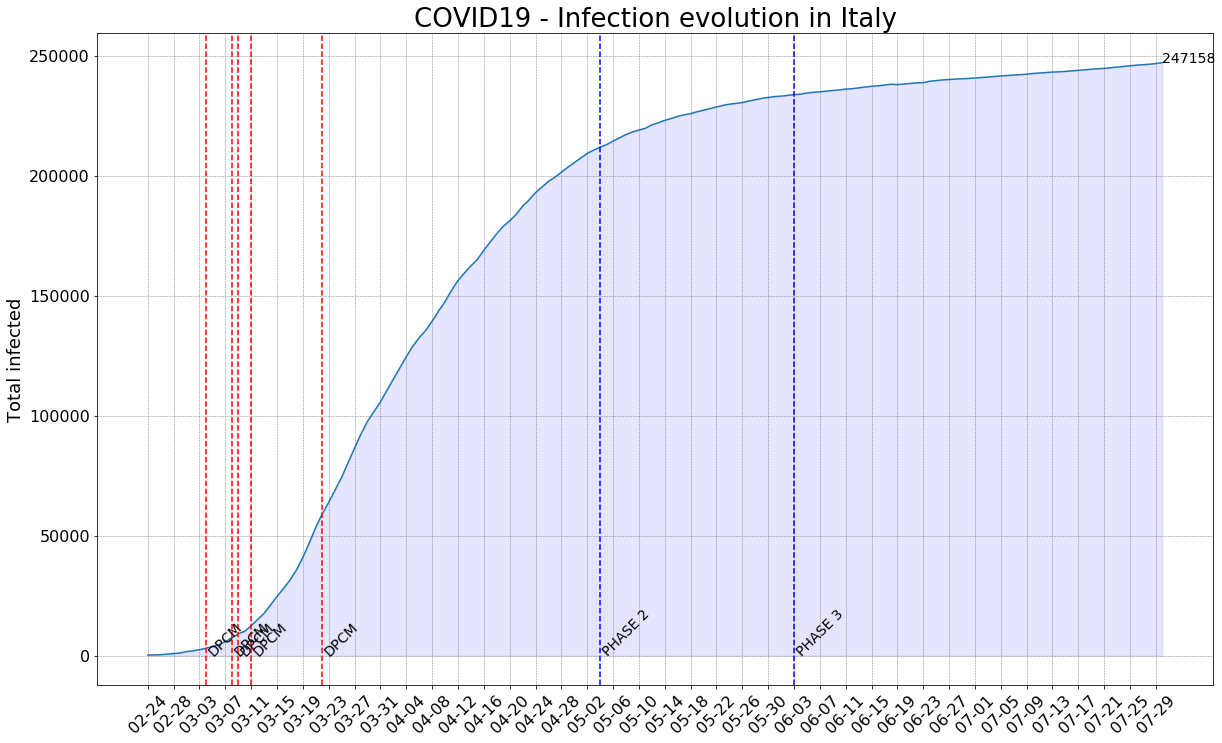

In [8]:
# Generate plot
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="totale_casi",
                  data=df_ita)
plt.fill_between(x='reference_day', y1='totale_casi', y2=0 ,data=df_ita, color='blue', alpha=.1)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('Total infected', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Infection evolution in Italy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
plt.text(df_ita.reference_day[len(df_ita)-1], 
         df_ita.totale_casi[len(df_ita)-1],
         df_ita.totale_casi[len(df_ita)-1], fontsize=14)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .3,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::4])
plt.savefig(f"{dir_path}/infection_evolution_ita.png")
plt.show()

In [9]:
def get_trend(series):
    from pandas import datetime
    from sklearn.linear_model import LinearRegression
    from matplotlib import pyplot
    import numpy
     
    def parser(x):
        return datetime.strptime('190'+x, '%Y-%m')
     
    series = series.dropna()
    # fit linear model
    X = [i for i in range(0, len(series))]
    X = numpy.reshape(X, (len(X), 1))
    y = series.values
    model = LinearRegression()
    model.fit(X, y)
    # calculate trend
    trend = model.predict(X)
    return trend

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


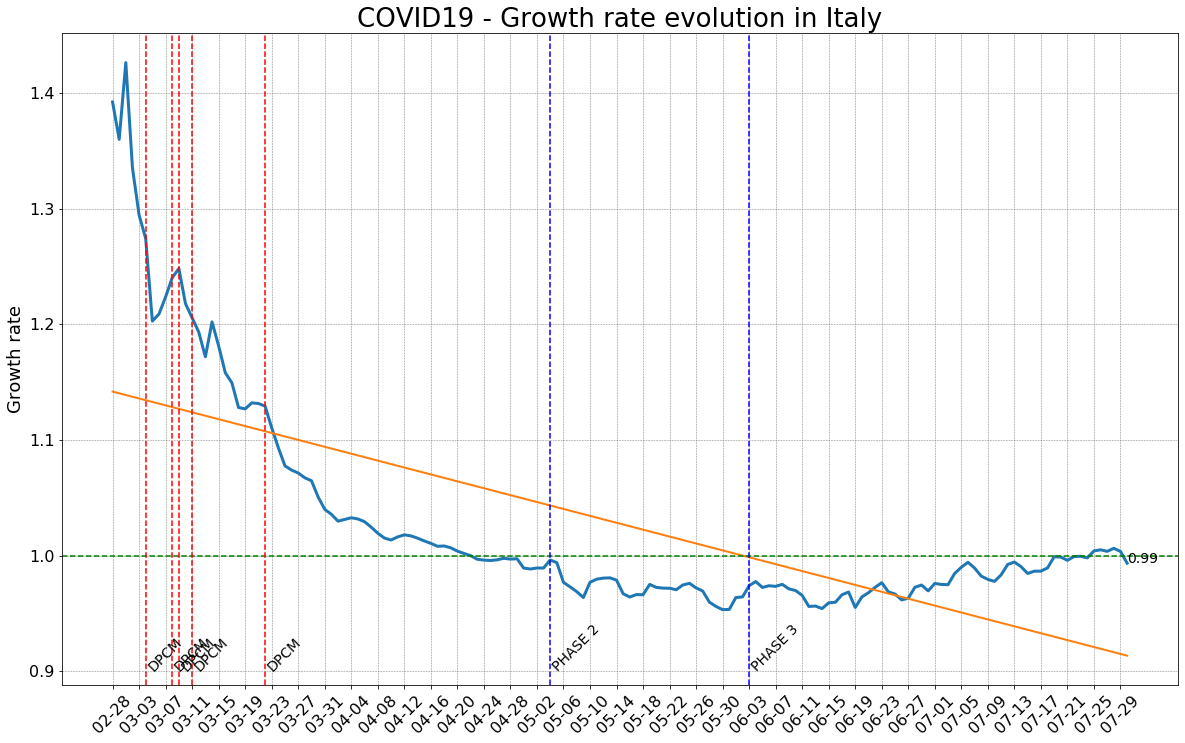

In [10]:
# Generate plot
df_gr = df_ita[["reference_day", "growth_rate"]].dropna().copy()
df_gr["growth_rate"] = df_gr.growth_rate.rolling(window=4).mean()
df_gr.dropna(inplace=True)
df_gr["trend"] = get_trend(df_gr["growth_rate"])
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="growth_rate",
                  data=df_gr, lw=3)
ax = sns.lineplot(x="reference_day", y="trend",
                  data=df_gr, lw=2)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('Growth rate', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Growth rate evolution in Italy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
#plt.ylim(bottom=0, top=1.6)
ax.axhline(1, ls='--', color='green', lw=1.5)
plt.text(df_gr.reference_day[len(df_ita)-1], 
         df_gr.growth_rate[len(df_ita)-1],
         round(df_gr.growth_rate[len(df_ita)-1],2), fontsize=14)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .9,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .9,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .9,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::4])
plt.savefig(f"{dir_path}/growth_rate_ita.png")
plt.show()

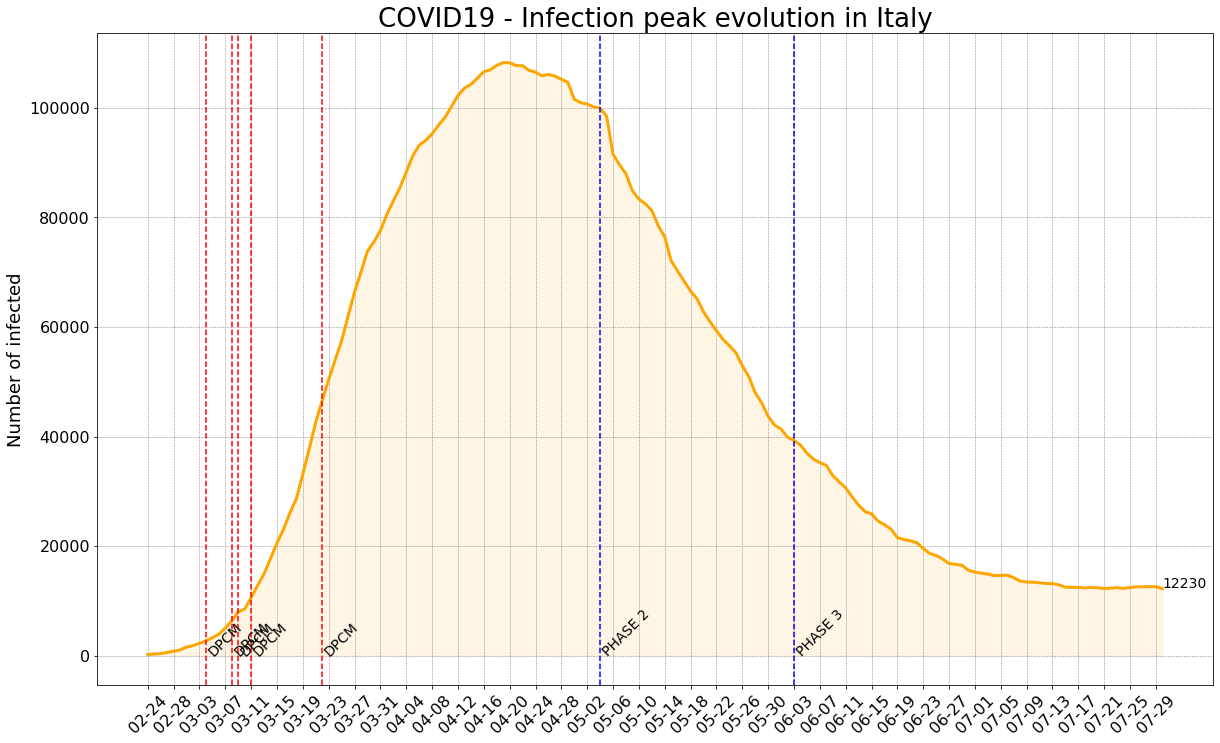

In [11]:
# What does the peak look like?
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="totale_positivi",
                  data=df_ita, lw=3, color='orange')
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.fill_between(x='reference_day', y1='totale_positivi', y2=0 ,data=df_ita, color='orange', alpha=.1)
plt.ylabel('Number of infected', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Infection peak evolution in Italy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
plt.text(df_ita.reference_day[len(df_ita)-1], 
         df_ita.totale_positivi[len(df_ita)-1]+144,
         df_ita.totale_positivi[len(df_ita)-1], fontsize=14)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .5,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::4])
plt.savefig(f"{dir_path}/peak_evolution_ita.png")
plt.show()

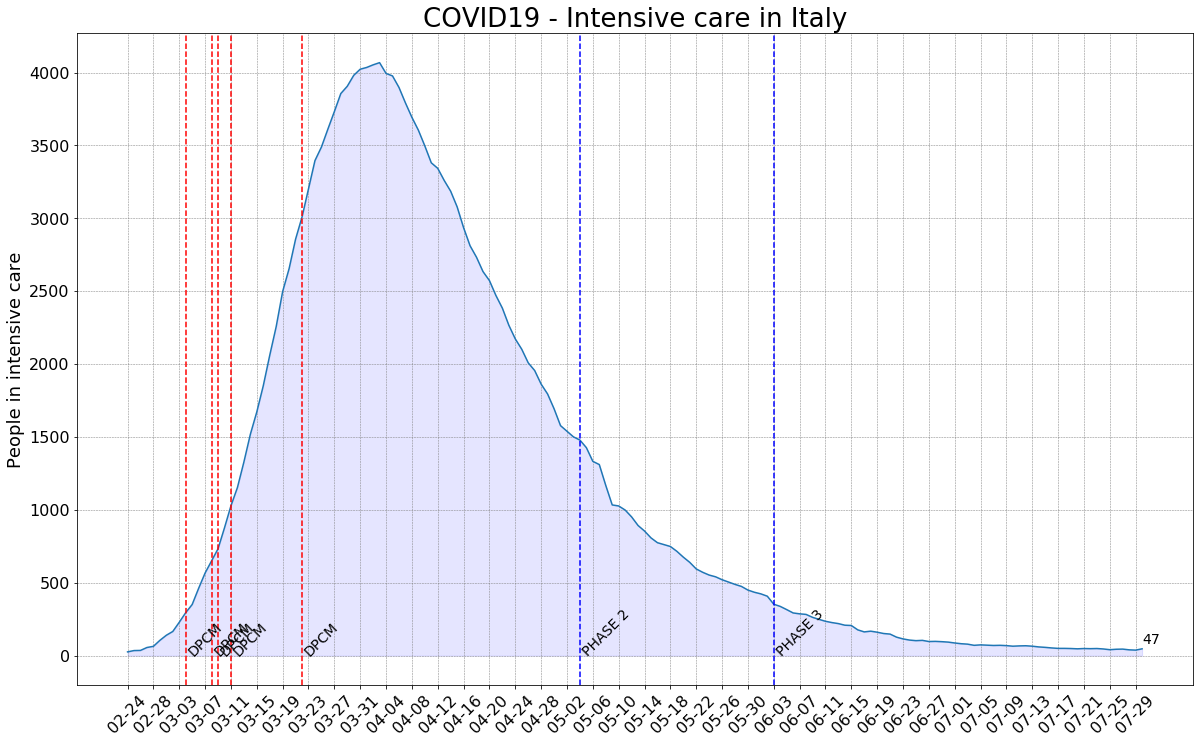

In [12]:
# Generate plot
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="terapia_intensiva",
                  data=df_ita)
plt.fill_between(x='reference_day', y1='terapia_intensiva', y2=0 ,data=df_ita, color='blue', alpha=.1)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('People in intensive care', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Intensive care in Italy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
plt.text(df_ita.reference_day[len(df_ita)-1], 
         df_ita.terapia_intensiva[len(df_ita)-1]+34,
         df_ita.terapia_intensiva[len(df_ita)-1], fontsize=14)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .3,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::4])
plt.savefig(f"{dir_path}/intensive_care_ita.png")
plt.show()